We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import collections
pd.options.mode.chained_assignment = None
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Flight Fare EDA.

In [2]:
### DATA PREPARATION
flightfare = pd.read_excel('C:\\Users\\Shekhar Lamba\\Desktop\\Python\\Projects\\Flight\Data_Train.xlsx')

df = pd.DataFrame(flightfare)

df['Destination'] = df['Destination'].replace('New Delhi', 'Delhi')

df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format = '%d/%m/%Y')

df['Weekday_of_Journey'] = df['Date_of_Journey'].dt.weekday
df['Day_of_Journey'] = df['Date_of_Journey'].dt.day
df['Month_of_Journey'] = df['Date_of_Journey'].dt.month
df.drop(['Date_of_Journey'], axis = 1, inplace = True)

df['Weekend_Journey'] = np.where(df['Weekday_of_Journey'] >= 5, 1, 0)
df.drop(['Weekday_of_Journey'], axis = 1, inplace = True)

df['Dep_Hour'] = pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.hour
df['Dep_Mins'] = pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.minute
df.drop(['Dep_Time'], axis = 1, inplace = True)

df['Next_Day_Arrival'] = 0
row_range = range(0, len(df))
for row in row_range: 
    df['Next_Day_Arrival'][row] = np.where((len(df['Arrival_Time'][row]) > 5), 1, 0)

df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Mins'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop(['Arrival_Time'], axis = 1, inplace = True)

row_range = range(0, len(df))
for row in row_range:
    if(len(df['Duration'][row]) <= 3):
        if 'h' in df['Duration'][row]:
            df['Duration'][row] = df['Duration'][row] + ' 0m'
        elif 'm' in df['Duration'][row]:
            df['Duration'][row] = '0h ' + df['Duration'][row]

df['Duration_in_minutes'] = 0
row_range = range(0, len(df))
for row in row_range:
    df['Duration_in_minutes'][row] = (int(df['Duration'][row].split('h ')[0]) * 60) + int(df['Duration'][row].split('h ')[1].replace('m', ''))

df.drop(['Duration'], axis = 1, inplace = True)

df['Flight_Route'] = 0
x_values = range(0, len(df))
for x in x_values:
    route = str(df['Route'][x])
    stops = route.count('→')
    if (stops == 1):
        df['Flight_Route'][x] = 'Direct'
    else:
        df['Flight_Route'][x] = df['Route'][x]

top_routes = df['Flight_Route'].value_counts().index[:6]
df['Flight_Route'] = np.where(df['Flight_Route'].isin(top_routes), df['Flight_Route'], 'Other')

df.drop(['Route'], axis = 1, inplace = True)
df.drop(['Additional_Info'], axis = 1, inplace = True)

df['Weekend_Journey'] = df['Weekend_Journey'].astype('int64')

df = df.dropna()

num_vars = df.select_dtypes(include = ['int64'])
cat_vars = df.select_dtypes(include = ['object'])
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]
feature_names

pair = num_vars[['Price', 'Duration_in_minutes']]

for col in df.columns:
    if col in pair.columns:
        percentile = df[col].quantile([0.05, 0.95]).values
        df[col] = df[col].clip(lower = percentile[0], upper = percentile[1])

stops_mapper = {'non-stop': 0,
         '1 stop': 1,
         '2 stops': 2,
         '3 stops': 3,
         '4 stops': 4}
df['Total_Stops'] = df['Total_Stops'].replace(stops_mapper)

df['Flight_Route'] = df['Flight_Route'].replace(['DEL → BOM → COK', 'CCU → BOM → BLR', 'CCU → DEL → BLR', 'BLR → BOM → DEL',
                                                'DEL → HYD → COK'], ['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'])
df = df.rename(columns = {'Flight_Route': 'Route'})

df_final = pd.get_dummies(df, columns = ['Airline', 'Source', 'Destination', 'Route'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['Price'], axis = 1)
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 99)

We now go on to make a simple XGBoost model, which will serve as our baseline. Few things to keep in mind here are the learning objective, which we set as reg and squarederror since we are performing regression with squarederror as the loss function. Also, fitting the model to the training data requires specifying few parameters: 

1. early_stopping_rounds: terminates the training process if the metric on the evaluation set doesnt improve after said rounds
2. eval_metric: the metric to be considered for early stopping
3. eval_set: the evaluation set to be considered for early stopping

So, we build the model, fit it to the training data and use it to get predictions for the testing set. We then calculate the following metrics:

1. MAE: It stands for Mean Absolute Error. It is calculated by taking the mean of the absolute difference between the dependent variable values and their respective predicted values acquired from the model.
2. RMSE: It stands for Root Mean Squared Error. It is calculated by first taking the difference between the dependent variable values and their respective predicted values acquired from the model, then squaring each of them and taking the square root of their mean value. 
3. R-Squared: It is the proportion of variation in the dependent variable which is explained by the independent variables.

For a good model, the MAE and RMSE values should be as low as possible while the R-Squared value should be closer to 1.

In [4]:
### CREATING A BASELINE MODEL AND CALCULATING ESSENTIAL METRICS
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 99)
model_xgb.fit(X_train,
             y_train,
             early_stopping_rounds = 20,
             verbose = False,
             eval_metric = 'rmse',
             eval_set = [(X_test, y_test)])
y_pred_xgb = model_xgb.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_xgb))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('R-Squared: %f' % r2_score(y_test, y_pred_xgb))

MAE: 1043.127134
RMSE: 1458.658546
R-Squared: 0.856844


We see that MAE is about 1043.13 and RMSE is about 1458.66; both of these values seem quite high. R-Squared is about 0.8568 which means that right now, about 85.68% of the variation in price of flight tickets can explained by the independent features. Going forward, we shall try to improve these metrics.

In addition to these metrics, we shall also check if the errors are normally distributed. This is required for the error rates we are willing to accept when making decisions about the process. If the errors are not normal, incorrect decisions will be made more or less frequently than the stated confidence levels.

<Figure size 1152x864 with 0 Axes>

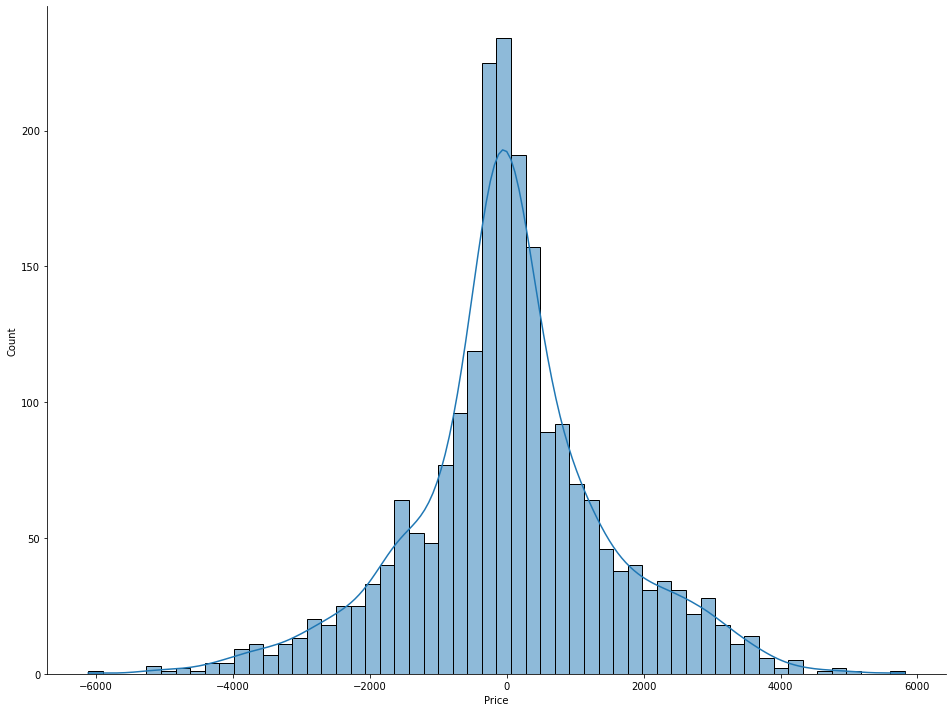

In [5]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_xgb), height = 10, aspect = 8/6, kde = True)

The distribution appears to be normal.

Next, we will try to further improve the model by tuning it's hyperparameters. For this, we shall use random search with 5 fold cross-validation across the possible values for the following hyperparameters:
1. n_estimators: the total number of trees to be built
2. learning_rate: it reduces the effect of individual trees thereby decreasing overfitting
3. max_depth: the maximum number of levels in each tree
4. min_child_weight: the minimum sum of the weights of all samples in a node required in order to make further splits
5. gamma: the minimum loss reduction required to make further splits
6. subsample: percent of the total samples to be considered while building each tree
7. colsample_bytree: percent of the total features to be considered while building each tree
8. reg_lambda: L2 regularization term on weights
9. reg_alpha: L1 regularization term on weights

We will be using R-squared value as our scoring parameter.

In [6]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions = {
    'n_estimators': range(100, 1000, 100),
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': range(3, 15),
    'min_child_weight': range(1, 10),
    'gamma': [i/10 for i in range(0, 10)],
    'subsample': [i/100 for i in range(65, 90, 5)],
    'colsample_bytree': [i/100 for i in range(65, 90, 5)],
    'reg_lambda': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 5, 10, 15, 20],
    'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 5, 10, 15, 20]
}
xg = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 99)
random_fit = RandomizedSearchCV(estimator = xg,
                               param_distributions = param_distributions,
                               scoring = 'r2',
                               n_iter = 30,
                               cv = 5,
                               random_state = 99,
                               verbose = 2,
                               n_jobs = -1)
random_fit.fit(X_train,
              y_train,
              early_stopping_rounds = 30,
              verbose = False,
              eval_metric = 'rmse',
              eval_set = [(X_test, y_test)])
print(random_fit.best_params_)
print('Best R-Squared: %f' % random_fit.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.2min finished


{'subsample': 0.85, 'reg_lambda': 5, 'reg_alpha': 20, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.9, 'colsample_bytree': 0.7}
Best R-Squared: 0.862055


Now, with these tuned hyperparameter values, we shall create our final XGBoost model.

In [7]:
### CREATING THE IMPROVED MODEL AND CALCULATING ESSENTIAL METRICS
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                            seed = 99,
                            subsample = 0.85, 
                            reg_lambda = 5,
                            reg_alpha = 20,
                            n_estimators = 700,
                            min_child_weight = 3,
                            max_depth = 6,
                            learning_rate = 0.1,
                            gamma = 0.9,
                            colsample_bytree = 0.7)
model_xgb.fit(X_train,
             y_train,
             early_stopping_rounds = 30,
             verbose = False,
             eval_metric = 'rmse',
             eval_set = [(X_test, y_test)])
y_pred_xgb = model_xgb.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_xgb))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('R-Squared: %f' % r2_score(y_test, y_pred_xgb))

MAE: 1052.272024
RMSE: 1456.760964
R-Squared: 0.857216


We see that the MAE has increased from about 1043.13 to about 1052.27 while the RMSE has slightly reduced to about 1456.76 from it's initial value of about 1458.66. The R-Squared value has increased from about 0.8568 to almost 0.8572 which means that currently, almost 85.72% of the variation in price of flight tickets can explained by the independent features.

We can also plot the errors to see if they are normally distributed.

<Figure size 1152x864 with 0 Axes>

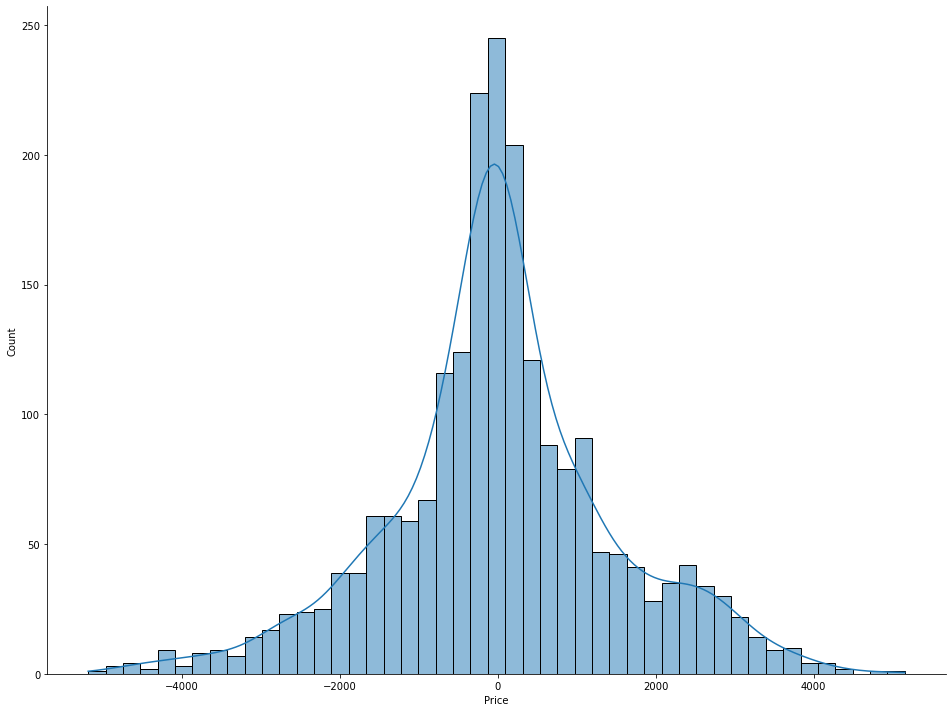

In [9]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_xgb), height = 10, aspect = 8/6, kde = True)

We see that there isn't much difference in the two plots except for the appearance of what looks to be a bulge in the second plot between the ranges 2000 and 4000. This might mean that the first model is more liekly to be the better one even though the R-Squared value for the second model was slightly better which might hint at overfitting. 